**Lab 4**

Problem 1

1)
We are gong to be looking at a large dataset this week of 25 million rows
Lets first import it

In [109]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import math
from scipy import optimize

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')


In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))
data[1]

array([315.        , 315.00711228, 315.01422457, ..., 345.31910877,
       345.32622105, 345.33333333])

In [5]:
hf.close

<bound method File.close of <HDF5 file "gammaray_lab4.h5" (mode r)>>

In [6]:
Data = pd.DataFrame({'time':data[0], 'Solar phase' : data[1] , 'Earth phase':data[2], 'particle counts':data[3]})

Now let’s look through the data to find a way to model the background, we have data for particle count in a 100 millisecond window as well as meta data for the earth phase and solar phase

Looking at the particle counts vs time graph we see some periodic counts lets look to see if this could have somthhing to do with the earth or the solar phases

In [ ]:

plt.hist(Data['time'],weights=Data['particle counts'], bins=5000)
#plt.yscale('log')
plt.xlabel('time')
plt.ylabel('particle counts')
plt.title('Particle counts over the whole data set')
plt.show()

plt.hist(Data['time'],weights=Data['particle counts'], bins=5000)
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('particle counts')
plt.title('Particle counts over the whole data set on a log scale')
plt.show()

Below we can see that there really is not a corilations of the particl counts to the solar phase

In [ ]:
plt.hist(Data['Solar phase'],weights=Data['particle counts'], bins=500)
plt.xlabel('Solar phase')
plt.ylabel('particle counts')
plt.title('Particle counts vs Solor phase on log scale histagram')

#plt.yscale('log')
plt.show()
plt.hist(Data['Solar phase'],weights=Data['particle counts'], bins=500)
plt.xlabel('Solar phase')
plt.ylabel('particle counts')
plt.title('Particle counts vs Solor phase on log scale histagram')

plt.yscale('log')
plt.show()

Now when looking at the partcle counts vs the earth phase we see a nice ditsrbuint this is going to be how we make the background

In [ ]:
plt.hist(Data['Earth phase'],weights=Data['particle counts'], bins=500)
plt.yscale('log')
plt.ylabel('particle counts')
plt.xlabel('Earth phase')
plt.title('Particle counts vs earth phase on log scale histagram')
plt.show()

plt.hist(Data['Earth phase'],weights=Data['particle counts'], bins=500)
#plt.yscale('log')
plt.ylabel('particle counts')
plt.xlabel('Earth phase')
plt.title('Particle counts vs earth phase histagram')
plt.show()

Lets make sure that the phase changes consitatly over time since we are going to want to find a time depence for the phase

In [ ]:
Diff = Data['Earth phase'].diff()
plt.ylabel('rate of change of the earth phase')
plt.xlabel('Time')
plt.title('Rate of change of the earth phase vs time ')
plt.hist(Data['time'],weights=Diff, bins=500)
plt.show()
Diff = Data['Earth phase'].diff()
plt.ylabel('rate of change of the earth phase')
plt.title('Rate of change of the earth phase vs time ')
plt.xlabel('Time')
plt.hist(Data['time'],weights=Diff, bins=500)
plt.ylim([0,-20])
plt.show()

Looking at the data we see signal contamination that has a depence on the earths phase. Now to get a backgound we will find the depencence of the partial count to the earth phase. That will give us an avrage count that we can use to build a poission backgound ditribution to then use to find signifgance of signals. 

In [11]:
#count , bins = np.histogram(Data['Earth phase'],weights=Data['particle counts'],bins=25000000)

In [13]:
#Data.nunique()

time               25920001
Solar phase        25920001
Earth phase          327040
particle counts          31
dtype: int64

In [105]:
Data.head(10)
Data.at[2,'Earth phase']

45.01333333651225

In [17]:
Data.nsmallest(10, 'particle counts')

,time,Solar phase,Earth phase,particle counts
382,940680054.2,317.716891,47.546667,0.0
476,940680063.6,318.385446,48.173333,0.0
535,940680069.5,318.805071,48.566667,0.0
565,940680072.5,319.018439,48.766667,0.0
959,940680111.9,321.820678,51.393333,0.0
2852,940680301.2,335.284226,64.013333,0.0
3310,940680347.0,338.541651,67.066667,0.0
7207,940680736.7,6.258212,93.046667,0.0
9385,940680954.5,21.748761,107.566667,0.0
11310,940681147.0,35.439902,120.400000,0.0


In [18]:
DataSort=Data.sort_values(by='particle counts')

In [22]:
DataSort.tail(100)

,time,Solar phase,Earth phase,particle counts
20677369,942747752.9,138.266497,14.126667,26.0
17430392,942423055.2,84.852443,327.613333,26.0
314338,940711449.8,30.660304,340.586667,26.0
24016722,943081688.2,128.684656,316.480000,26.0
21263046,942806320.6,343.766118,318.640000,26.0
...,...,...,...,...
21490312,942829047.2,160.145858,33.746667,29.0
8033129,941483328.9,208.873799,319.193333,29.0
7173853,941397401.3,217.461105,350.686667,30.0
9113934,941591409.4,335.863074,324.560000,30.0


In [23]:
DataSort.head(100)

,time,Solar phase,Earth phase,particle counts
4188000,941098816.0,221.234414,245.000000,0.0
10319502,941711966.2,270.201911,81.680000,0.0
3004533,940980469.3,84.084107,275.220000,0.0
16929486,942372964.6,122.268027,228.240000,0.0
17859673,942465983.3,258.019706,309.486667,0.0
...,...,...,...,...
6620589,941342074.9,242.491860,262.260000,0.0
5113379,941191353.9,322.790243,294.193333,0.0
11088420,941788858.0,338.963084,167.800000,0.0
9911246,941671140.6,246.570365,239.973333,0.0


In [24]:
25920001/327040

79.25636313600783

In [15]:
(360/(Data.at[1,'Earth phase']-Data.at[0,'Earth phase']))

53999.98712540363

In [35]:
25920001/(10*60)

43200.00166666666

In [7]:
DataSortEP=Data.sort_values(by='Earth phase')

In [103]:
pd.set_option('display.max_rows', 100, "display.max_columns", None)

In [68]:
n=6751
DataSortEP[0+480*n:481+480*n]

,time,Solar phase,Earth phase,particle counts
3024000,940982416.0,222.538889,45.000000,9.0
17118001,942391816.1,23.039751,45.006667,5.0
...,...,...,...,...
2700001,940950016.1,78.166835,45.006667,7.0
3348001,941014816.1,6.925168,45.006667,11.0


In [73]:
D = Data[(Data["Earth phase"] == 0)]

#filterdtmp  =temp[temp['sigma'] > 4]

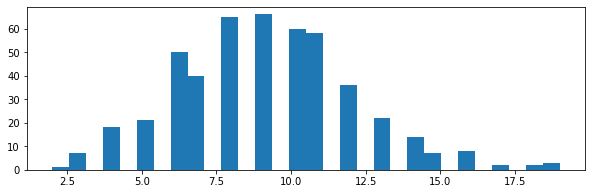

In [80]:
len(D)
D
plt.hist(D['particle counts'], bins=30)
plt.show()

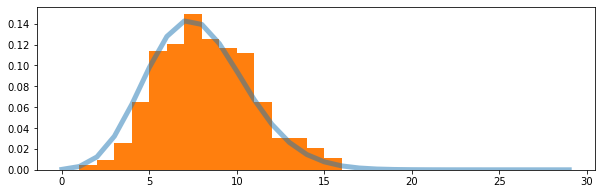

,time,Solar phase,Earth phase,particle counts
5,940680016.5,315.035561,45.033333,11.0
54005,940685416.5,339.098756,45.033333,9.0
108006,940690816.6,3.169063,45.040000,5.0
324006,940712416.6,99.421840,45.040000,7.0
378006,940717816.6,123.485035,45.040000,11.0
...,...,...,...,...
25650006,943245016.6,225.060035,45.040000,11.0
25704006,943250416.6,249.123229,45.040000,9.0
25758006,943255816.6,273.186424,45.040000,5.0
25812006,943261216.6,297.249618,45.040000,9.0


In [150]:
n=5


D = Data[(Data["Earth phase"] < Data.at[n+1,'Earth phase'])]
D = D[(D["Earth phase"] >= Data.at[n,'Earth phase'])]
len(D)

mu=D.mean()
mu[3]

fig, ax = plt.subplots(1,1)
x = np.arange(0,30,1)
ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5)

plt.hist(D['particle counts'], bins=15, density=True)
plt.show()
D


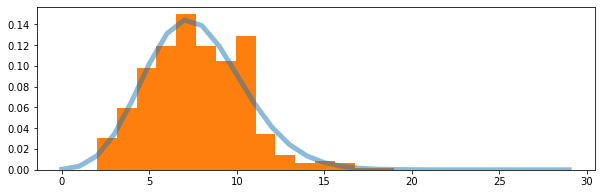

,time,Solar phase,Earth phase,particle counts
10,940680017.0,315.071123,45.066667,5.0
54011,940685417.1,339.141430,45.073333,6.0
108010,940690817.0,3.197512,45.066667,11.0
324011,940712417.1,99.457402,45.073333,5.0
378011,940717817.1,123.520596,45.073333,11.0
...,...,...,...,...
25650010,943245017.0,225.088484,45.066667,5.0
25704010,943250417.0,249.151678,45.066667,5.0
25758010,943255817.0,273.214873,45.066667,8.0
25812010,943261217.0,297.278067,45.066667,8.0


In [151]:
n=10


D = Data[(Data["Earth phase"] < Data.at[n+1,'Earth phase'])]
D = D[(D["Earth phase"] >= Data.at[n,'Earth phase'])]
len(D)

mu=D.mean()
mu[3]

fig, ax = plt.subplots(1,1)
x = np.arange(0,30,1)
ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5)

plt.hist(D['particle counts'], bins=15, density=True)
plt.show()

D



In [94]:
Data.at[1,'Earth phase']

45.00666666825612

In [23]:
Hist = pd.DataFrame({ 'Earth phase':bins, 'particle counts':count, 'd':np.append(np.diff(count),0)})


In [101]:
D = Data[(Data["Earth phase"] == Data.at[2,'Earth phase'])]
D
Data.at[2,'Earth phase']

45.01333333651225

In [25]:
d = np.append(np.diff(count),0)
d= np.append(d,0)

In [ ]:
s=np.append(Hist.loc[339:500],Hist.loc[0:335])

In [ ]:
plt.hist(Data['time'].iloc[0:200000],weights=Data['Earth phase'].iloc[0:200000], bins=1000)
plt.yscale('log')

In [50]:
t = Data['time']
Ep = Data['Earth phase']
Sp = Data['Earth phase']
c = Data['particle counts']